# Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import math as math
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn import preprocessing

In [3]:
DIR_DATA_ANIMATIONS = '../data/animations/'

## 1. Clean and Prepare Data

### 1.1. Data Overview

In [4]:
df = pd.read_csv('../data/albert_heijn/ah_data.csv')
df_original = df.copy() # keep copy of original dataframe
print('Number of rows before data cleaning: ' + str(len(df)))

Number of rows before data cleaning: 17072


In [5]:
df.head()

product  \
0         De Zaanse Hoeve Roomboter ongezouten   
1                 AH Halvarine lekker op brood   
2                      AH Zuivelspread naturel   
3  AH Luchtige cracker volkoren met rijstbloem   
4                         AH Smeerkaas naturel   

                                                 url  \
0  https://www.ah.nl/producten/product/wi429615/d...   
1  https://www.ah.nl/producten/product/wi127489/a...   
2  https://www.ah.nl/producten/product/wi506228/a...   
3  https://www.ah.nl/producten/product/wi196377/a...   
4  https://www.ah.nl/producten/product/wi249/ah-s...   

                                          category  price  amount  \
0  ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   2.49   250.0   
1  ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   1.09   500.0   
2  ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   0.79   200.0   
3  ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   0.99   250.0   
4  ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   0.79   100.0   

                                             content unit  vegan  vegetarian  \
0  Inhoud en gewicht250 GramPortiegrootte: 5 gram...    g  False        True   
1  Inhoud en gewicht500 GramPortiegrootte: 5 gram...    g   True        True   
2  Inhoud en gewicht200 GramPortiegrootte: 15 gra...    g  False        True   
3  Inhoud en gewicht250 GramPortiegrootte: 7,5 gr...    g   True        True   
4  Inhoud en gewicht100 GramPortiegrootte: 15 gra...    g  False       False   

  nutriscore  carbs_100g  protein_100g  fat_100g  alcohol_100g  
0          E         1.0           0.6      82.0           NaN  
1          C         0.6           0.0      39.0           NaN  
2          D         3.3           7.8      16.0           NaN  
3          A        63.0          10.0       3.6           NaN  
4          D         2.4          14.0      21.0           NaN

In [6]:
# Number of NAs per field:
df.isna().sum()

product             0
url                 0
category            0
price               7
amount           1489
content           441
unit             1489
vegan               0
vegetarian          0
nutriscore       9364
carbs_100g        932
protein_100g      934
fat_100g          953
alcohol_100g    16948
dtype: int64

In [7]:
# Number of Products per Category
df.groupby(["category"])["product"].count()

category
aardappel-groente-fruit?minPrice=0&maxPrice=2.99             874
aardappel-groente-fruit?minPrice=3&maxPrice=99               316
bakkerij-en-banket                                           981
diepvries                                                    861
kaas-vleeswaren-tapas?minPrice=0&maxPrice=2.99               849
kaas-vleeswaren-tapas?minPrice=3&maxPrice=99                 627
ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60              886
ontbijtgranen-en-beleg?minPrice=2.61&maxPrice=99             966
pasta-rijst-en-wereldkeuken?minPrice=0&maxPrice=1.99         796
pasta-rijst-en-wereldkeuken?minPrice=2&maxPrice=3.99         993
pasta-rijst-en-wereldkeuken?minPrice=4&maxPrice=99           233
salades-pizza-maaltijden                                     655
snoep-koek-chips-en-chocolade?minPrice=0&maxPrice=1.89       926
snoep-koek-chips-en-chocolade?minPrice=1.90&maxPrice=2.59    940
snoep-koek-chips-en-chocolade?minPrice=2.60&maxPrice=99      876
soepen-sauzen-kr

### 1.2 Remove Duplicate Products

In [8]:
print('Number of rows before deleting duplicates: ' + str(len(df)))
df = df.drop_duplicates('url', keep='last')
print('Number of rows after deleting duplicates: ' + str(len(df)))

Number of rows before deleting duplicates: 17072
Number of rows after deleting duplicates: 11852


### 1.3. Estimate amount for missing or inexact amount values based on 'content' label

In [9]:
def get_content_amount(content):
    if str(content) == "nan":
        amount = np.NaN
        content_type = "1: Content = NaN"
    else:
        content = content.lower()
        if re.search('gewicht[\d]* gram',content) and content.lower().find('liter')==-1:
            # get total amount label ('gewicht'). Does not work for liquids (ml or liters)
            amount = re.search('gewicht[\d]* gram',content)[0]
            amount = amount.rstrip(' gram').strip('gewicht').replace(',','.')
            amount = float(amount)
            content_type = "2: Total weight in g"
        elif re.search('portiegrootte: [\d\,]* gram',content) and re.search('antal porties: [\d\,]*',content):
            # get portion size and nr of portions
            portion_size = re.search('portiegrootte: [\d\,]* gram',content)[0]
            portion_size = portion_size.rstrip(' gram').strip('portiegrootte: ').replace(',','.')
            portion_size = float(portion_size)
            number_of_portions = re.search('antal porties: [\d\,]*',content)[0]
            number_of_portions = number_of_portions.strip('antal porties: ')
            number_of_portions = float(number_of_portions)
            amount = portion_size * number_of_portions
            content_type = "3: portion_size * number_of_portions"
        else:
            amount = np.NaN
            content_type = "4: NaN (Unknown content format)"
    return amount, content_type

In [10]:
def amount_not_exact(amount):
    if str(amount) == 'nan':
        not_exact = True
    elif amount > 6.5 and amount - math.floor(amount)>0:
        # if number has decimals then amount value was not accurate enough
        # add 6.5 limit to exclude small products like spices
        not_exact = True
    else:
        not_exact = False
    return not_exact

In [11]:
# Estimate amounts based on label
df['amount_old'] = df['amount'] # create copy of amount column
df['amount_content'] = df['content'].apply(lambda x: get_content_amount(x)[0])
df['content_type'] = df['content'].apply(lambda x: get_content_amount(x)[1])
print("Types of 'Content' for Products with no Amount:")
df[df['unit'].isna()].groupby(["content_type"]).count()["product"]
# We are able to estimate more than 50% of missing amounts using the content label (types 2 and 3)

Types of 'Content' for Products with no Amount:


content_type
1: Content = NaN                        276
2: Total weight in g                    370
3: portion_size * number_of_portions    142
4: NaN (Unknown content format)         253
Name: product, dtype: int64

In [12]:
print('Number of products with inexact amounts (either missing or poorly estimated):')
print(sum([amount_not_exact(x) for x in df['amount']]))

Number of products with inexact amounts (either missing or poorly estimated):
1365


In [13]:
# Change amounts that are not exact AND have a valid estimate from the 'content' label
amounts_to_change = [amount_not_exact(x) for x in df['amount']] & df['amount_content'].notna()
print("Amounts before being changed:")
df[amounts_to_change]['amount']

Amounts before being changed:


21       132.352941
427             NaN
918      121.111111
924      121.428571
943             NaN
            ...    
17067           NaN
17068           NaN
17069           NaN
17070           NaN
17071           NaN
Name: amount, Length: 679, dtype: float64

In [14]:
df.loc[amounts_to_change, 'amount'] = df[amounts_to_change]['amount_content'] # Update amounts
df.loc[amounts_to_change, 'unit'] = 'g' # Update unit

In [15]:
print("Amounts after being changed:")
df[amounts_to_change]['amount']
# amount now have the exact values

Amounts after being changed:


21        130.0
427       200.0
918       120.0
924       120.0
943       100.0
          ...  
17067     146.0
17068     202.0
17069     182.0
17070     212.0
17071    1030.0
Name: amount, Length: 679, dtype: float64

In [16]:
print("Number of products which still have missing amounts (these will have to be deleted):")
print(sum(df['unit'].isna()))

Number of products which still have missing amounts (these will have to be deleted):
529


### 1.4 Remove/Update NAs

In [17]:
# Drop records where amount could not be estimated
df = df.dropna(subset=['unit'])
print('Number of rows before data cleaning: ' + str(len(df)))

Number of rows before data cleaning: 11323


In [18]:
print('Number of products with inexact amounts:')
print(sum([amount_not_exact(x) for x in df['amount']]))

Number of products with inexact amounts:
158


In [19]:
# Round remaining inexact amounts. In most cases this results in the correct amount:
df.loc[[amount_not_exact(x) for x in df['amount']], 'amount'] = [round(x) for x in df[[amount_not_exact(x) for x in df['amount']]]['amount']]

In [20]:
print('Number of products with inexact amounts:')
print(sum([amount_not_exact(x) for x in df['amount']]))

Number of products with inexact amounts:
0


In [21]:
# Fill NAs of numeric columns with zero
df['carbs_100g'] = df['carbs_100g'].fillna(0)
df['protein_100g'] = df['protein_100g'].fillna(0)
df['fat_100g'] = df['fat_100g'].fillna(0)
df['alcohol_100g'] = df['alcohol_100g'].fillna(0)

### 1.5 Delete/Edit Outliers
#### Some products have wrong nutritional data in the website and need to be fixed

In [22]:
# Delete products with wrong nutritional data:
df = df.drop(df[df['product'] == 'Molino Rossetto Fijne tarwebloem'].index) # wrong carbs
df = df.drop(df[df['product'] == 'Iglo Bladspinazie'].index) # wrong carbs
df = df.drop(df[df['product'] == 'Chan\'s Asi no moto'].index) # wrong protein

In [74]:
# Correct products that are actually vegan
df.loc[df['product'] == 'Vandemoortele Frituurolie minder geuren', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'AH Bak en braad', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Kristalsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Lubelskie Mtyny Wheat flower', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Vandemoortele Frituurolie minder geuren', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'AH Volkoren havermout', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Lichte basterdsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Molino Rossetto Zelfrijzend bakmeel', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Coppelia Zonnebloemolie', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Koolzaadolie', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Fijne kristalsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Pink Lady Pink lady appel los', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Witte basterdsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Donkere basterdsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Abaco Zonnebloemolie', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Koopmans Cakemeel', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'King Rijstolie - frituurolie', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Molensteen Biologisch tarwebloem', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Smaakt Grove sojastukjes', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'AH Macaroni', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Conimex Ketjap manis', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Valle del sole Groene spliterwten', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Valle del sole Gele spliterwten', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Valle del sole Rode splitlinzen', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Valle del sole Zwarte oogbonen', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Valle del sole Groene linzen', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Raw Organic Food Spirulinapoeder', ['vegan','vegetarian']] = True

In [75]:
# Red lentils had wrong nutritional facts. I checked them in the supermarket myself
df.loc[df['product'] == 'Valle del sole Rode splitlinzen', ['carbs_100g','protein_100g','fat_100g']] = [56, 24, 2]

In [76]:
print('Number of rows after data cleaning: ' + str(len(df)))

Number of rows after data cleaning: 11320


### 1.6 Add New Fields

In [77]:
# Calculate calories: 4 kcal per g of protein/carbs, 7 kcal per g of alcohol, 9 kcal per g of fat
df['calories_100g'] = df.apply(lambda x: x['carbs_100g'] * 4 + x['protein_100g'] * 4 + x['fat_100g'] * 9 + x['alcohol_100g'] * 7, axis = 1)

In [78]:
# Add total amount of macros
df['calories'] = df['calories_100g']*df['amount']/100
df['protein'] = df['protein_100g']*df['amount']/100
df['carbs'] = df['carbs_100g']*df['amount']/100
df['fat'] = df['fat_100g']*df['amount']/100
df['alcohol'] = df['alcohol_100g']*df['amount']/100

In [79]:
df

product  \
5              AH Volkoren havermout   
6               AH Beschuit volkoren   
21               AH Beschuit naturel   
24                         AH Honing   
34      Brinta Volkoren graanontbijt   
...                              ...   
17067     SUNT Donut lemon poppyseed   
17068  AH Karamel zeezout cheesecake   
17069      AH Cookie & cream slofjes   
17070      AH Salted caramel slofjes   
17071                  AH Dino taart   

                                                     url  \
5      https://www.ah.nl/producten/product/wi48405/ah...   
6      https://www.ah.nl/producten/product/wi1625/ah-...   
21     https://www.ah.nl/producten/product/wi1624/ah-...   
24     https://www.ah.nl/producten/product/wi479788/a...   
34     https://www.ah.nl/producten/product/wi166916/b...   
...                                                  ...   
17067  https://www.ah.nl/producten/product/wi537024/s...   
17068  https://www.ah.nl/producten/product/wi537027/a...   
17069  https://www.ah.nl/producten/product/wi537030/a...   
17070  https://www.ah.nl/producten/product/wi537031/a...   
17071  https://www.ah.nl/producten/product/wi537034/a...   

                                              category  price  amount  \
5      ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   0.69   500.0   
6      ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   0.49   140.0   
21     ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   0.45   130.0   
24     ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   1.99   350.0   
34     ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60   2.09   500.0   
...                                                ...    ...     ...   
17067                               bakkerij-en-banket   2.99   146.0   
17068                               bakkerij-en-banket   4.00   202.0   
17069                               bakkerij-en-banket   3.50   182.0   
17070                               bakkerij-en-banket   3.50   212.0   
17071                               bakkerij-en-banket  15.00  1030.0   

                                                 content unit  vegan  \
5      Inhoud en gewicht500 GramPortiegrootte: 40 gra...    g   True   
6      Inhoud en gewicht140 GramPortiegrootte: 11 gra...    g  False   
21     Inhoud en gewicht130 GramPortiegrootte: 10 gra...    g  False   
24     Inhoud en gewicht350 GramPortiegrootte: 15 gra...    g  False   
34           Inhoud en gewicht500 GramAantal porties: 14    g  False   
...                                                  ...  ...    ...   
17067     Inhoud en gewicht146 GramPortiegrootte: portie    g  False   
17068  Inhoud en gewicht2 StuksPortiegrootte: 101 gra...    g  False   
17069  Inhoud en gewicht2 StuksPortiegrootte: 91 gram...    g  False   
17070  Inhoud en gewicht212 GramPortiegrootte: 106 gr...    g  False   
17071  Inhoud en gewicht1 StuksPortiegrootte: 103 gra...    g  False   

       vegetarian nutriscore  ...  alcohol  price_1000_calories  \
5            True        NaN  ...      0.0             0.388732   
6            True          A  ...      0.0             0.919601   
21           True          A  ...      0.0             0.842634   
24           True          D  ...      0.0             1.746227   
34          False        NaN  ...      0.0             1.270131   
...           ...        ...  ...      ...                  ...   
17067       False        NaN  ...      0.0             6.168510   
17068        True          E  ...      0.0             5.865515   
17069        True          E  ...      0.0             4.296419   
17070       False          E  ...      0.0             4.661049   
17071        True          E  ...      0.0             3.118438   

       price_100g_protein  price_100g_carbs  price_100g_fat  \
5                0.985714          0.233898        1.971429   
6                2.333333          0.514706        6.481481   
21               2.307692          0.455466        6.656805   
24             142.142857   

## 2. Analyze Data

### 2.1. Add Auxiliary Columns

In [80]:
# # Price per g of each macro
# Price per g of each macro
df['price_1000_calories'] = 1000*df['price']/df['calories']
df['price_100g_protein'] = 100*df['price']/df['protein']
df['price_100g_carbs'] = 100*df['price']/df['carbs']
df['price_100g_fat'] = 100*df['price']/df['fat']

In [81]:
# Determine percentage of macro relative to total amount of calories:
df['perc_calories_protein'] = df['protein']*4/df['calories']
df['perc_calories_carbs'] = df['carbs']*4/df['calories']
df['perc_calories_fat'] = df['fat']*9/df['calories']
df['perc_calories_alcohol'] = df['alcohol']*7/df['calories']

In [104]:
# Add auxiliary identifier column
df['product_amount'] = df['product'] + ' ' + [str(round(x)) for x in df['amount']]

In [83]:
df.to_csv(DIR_DATA_ANIMATIONS + 'df_full.csv', index = False)

### 2.2. Tables with cheapest prices per gram of each macro

In [84]:
# Function to build bars with colors for each macro percentage
from PIL import Image, ImageDraw

def generate_macro_bars(df, number_of_bars, file_name):
    # Set the dimensions of the image
    width = 700
    height = 200

    # Create a new image with a white background
    image = Image.new("RGBA", (width, height), (255, 255, 255, 0))
    draw = ImageDraw.Draw(image)

    # Generate 10 bars with three colors each
    for i in range(number_of_bars):
        # Set the percentages for the three colors
        percentages = [df['perc_calories_carbs'].iloc[i], df['perc_calories_fat'].iloc[i], df['perc_calories_protein'].iloc[i]]
        total = sum(percentages)

        # Calculate the coordinates for the bars
        x = i * 60
        y = 0
        w = 50
        h = 150

        # Generate the bars with the three colors
        for j, percentage in enumerate(percentages):
            # Set the color for the bar
            if j == 0:
                color = "#f4b430"
            elif j == 1:
                color = "#2ec2a0"
            else:
                color = "#d83a33"

            # Calculate the height of the bar
            hh = percentage / total * h

            # Draw the bar
            draw.rectangle((x, y, x + w, y + hh), fill=color)

            # Shift the y-coordinate for the next bar
            y += hh

#             # Add a label with the percentage for the bar
#             draw.text((x + w + 5, y + h / 2 - 10), f"{percentage:.1f}%", fill=(0, 0, 0, 255))
        
    # Make the background transparent
    # image = image.putalpha(1)
    

    # Save the image
    image.save(DIR_DATA_ANIMATIONS + file_name)

In [85]:
# Cheapest Calories
df.sort_values(by=['price_1000_calories']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_calories.csv', index = False)
generate_macro_bars(df.sort_values(by=['price_1000_calories']), 10, "bars_calories.png")
df.sort_values(by=['price_1000_calories']).iloc[0:50][['product','vegan','price','amount','calories','price_1000_calories','perc_calories_protein','perc_calories_fat','perc_calories_carbs']]

product  vegan  price   amount  \
16131                           AH Tarwe bloem   True   0.79   1000.0   
16201                  Van Gilse Kristalsuiker   True   0.99   1000.0   
16114                         AH Kristalsuiker   True   0.99   1000.0   
16924                           AH Patentbloem   True   0.85   1000.0   
16188                     AH Patent tarwebloem   True   0.49    500.0   
16219                   AH Zelfrijzend bakmeel   True   0.99   1000.0   
11267                      AH Langkorrel rijst   True   5.19   4500.0   
16885             Lubelskie Mtyny Wheat flower   True   1.19   1000.0   
6725          AH Paneermeel naturel broodkruim   True   0.49    400.0   
16378                   AH Zelfrijzend bakmeel   True   0.59    500.0   
15398                             AH Margarine  False   1.29    500.0   
16344                    AH Volkoren tarwemeel   True   1.15   1000.0   
10635                               AH Slaolie   True   2.99   1000.0   
11248  Vandemoortele Frituurolie minder geuren   True   5.99   2000.0   
16174                        AH Suikerklontjes   True   1.49   1000.0   
8328                         AH Marie biscuits   True   0.65    400.0   
8300                             AH Kruidnoten  False   1.59   1000.0   
284                   AH Volkoren havervlokken   True   0.69    500.0   
5                        AH Volkoren havermout   True   0.69    500.0   
15468                          AH Bak en braad   True   0.85    250.0   
11258                           AH Frituurolie   True   9.69   3000.0   
8287                              AH Digestive   True   0.75    400.0   
16281           Van Gilse Lichte basterdsuiker   True   0.95    600.0   
16913      Molino Rossetto Zelfrijzend bakmeel   True   1.29   1000.0   
11792                             AH Mayonaise  False   1.61    650.0   
11227                   AH Vloeibaar fituurvet   True   9.99   3000.0   
6747                   AH Witte snelkook rijst   True   1.49   1000.0   
8353                           AH Theebiscuits   True   0.55    300.0   
11243                  Coppelia Zonnebloemolie   True   7.49   2000.0   
3917                              Koolzaadolie   True   3.79   1000.0   
15243                       AH Basis vloeibaar   True   1.99    750.0   
15487                          AH Bak en braad   True   2.59    750.0   
6695                        AH Langgraan rijst   True   1.49   1000.0   
6702                            AH Witte rijst   True   1.49   1000.0   
8254                      AH Bakkers speculaas   True   1.29    600.0   
16276            Van Gilse Fijne kristalsuiker   True   1.29    750.0   
15162            Pink Lady Pink lady appel los   True   2.99  12500.0   
15578                             AH Margarine  False   0.79    250.0   
8499                    AH Fourré vanillesmaak  False   1.09    500.0   
335                            AH Choco spread  False   1.89    750.0   
16218            Van Gilse Witte basterdsuiker   True   1.05    600.0   
16216          Van Gilse Donkere basterdsuiker   True   1.05    600.0   
4031                      Abaco Zonnebloemolie   True   3.99   1000.0   
11296                           AH Frituurolie   True   7.49   2000.0   
16590                        Koopmans Cakemeel   True   0.89    450.0   
3590                            Zonnebloemolie   True   3.79   1000.0   
16507                         AH Mix voor cake  False   0.79    400.0   
11307             King Rijstolie - frituurolie   True   7.69   2000.0   
10450                   AH Belgische Mayonaise  False   1.99    650.0   
6738                       AH Zilvervliesrijst   True   1.65   1000.0   

       calories  price_1000_calories  perc_calories_protein  \
16131    3419.0             0.231062               0.128693   
16201    4000.0             0.247500               0.000000   
16114    4000.0             0.247500               0.000000   
16924    3370.0             0.252226               0.118694   


In [86]:
# Cheapest Carbs
df.sort_values(by=['price_100g_carbs']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_carbs.csv', index = False)
df.sort_values(by=['price_100g_carbs']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','price_100g_carbs']]

product  vegan nutriscore  \
16201                            Van Gilse Kristalsuiker   True        NaN   
16114                                   AH Kristalsuiker   True          D   
16131                                     AH Tarwe bloem   True          A   
16924                                     AH Patentbloem   True          A   
16188                               AH Patent tarwebloem   True          A   
16219                             AH Zelfrijzend bakmeel   True          C   
11267                                AH Langkorrel rijst   True          A   
16174                                  AH Suikerklontjes   True          D   
16281                     Van Gilse Lichte basterdsuiker   True        NaN   
16885                       Lubelskie Mtyny Wheat flower   True        NaN   
16276                      Van Gilse Fijne kristalsuiker   True        NaN   
16378                             AH Zelfrijzend bakmeel   True          C   
6725                    AH Paneermeel naturel broodkruim   True          A   
16218                      Van Gilse Witte basterdsuiker   True        NaN   
16216                    Van Gilse Donkere basterdsuiker   True        NaN   
16344                              AH Volkoren tarwemeel   True          A   
15162                      Pink Lady Pink lady appel los   True        NaN   
6747                             AH Witte snelkook rijst   True          A   
16913                Molino Rossetto Zelfrijzend bakmeel   True        NaN   
16452                 Van Gilse Originele suikerklontjes  False        NaN   
6695                                  AH Langgraan rijst   True          A   
6702                                      AH Witte rijst   True          A   
8374                   AH Ontbijtkoek naturel ongesneden  False          C   
16932                              Van Gilse Geleisuiker  False        NaN   
8300                                       AH Kruidnoten  False          E   
6738                                 AH Zilvervliesrijst   True          A   
8328                                   AH Marie biscuits   True          D   
16814                           Valle del sole Maisbloem  False        NaN   
16238                             Wester Ruwe rietsuiker  False        NaN   
16728  Valle del sole Maisgriesmeel voor polenta bramata  False        NaN   
16293                      Van Gilse Mini suikerklontjes  False        NaN   
16295                           AH Biologisch Tarwebloem   True          A   
5                                  AH Volkoren havermout   True        NaN   
284                             AH Volkoren havervlokken   True          A   
2617                              Unirice Longgrain rice  False        NaN   
16320                                   AH Vanillesuiker   True          D   
16199                                        AH Wit heel   True          B   
15141                               AH Doyenné du Comice  False          A   
6650                            AH Vlugkokende spaghetti  False          A   
16846                     Molensteen Zelfrijzend bakmeel  False        NaN   
6536                                         AH Macaroni   True          A   
11237                                    AH Basmatirijst   True          A   
16598                   Molensteen Biologisch tarwebloem   True        NaN   
8353                                     AH Theebiscuits   True          D   
16477                     Caribbean Gold Ruwe rietsuiker  False          D   
6641                                     AH Pandan rijst   True          A   
16398                        AH Biologisch Kristalsuiker   True          D   
876                                   AH Gekleurde hagel  False          D   
6513                                AH Rinse appelstroop   True          C   
16226                                     Duryea Maizena  False        NaN   

       price   amount  calories  price_100g_carbs  
16201   0.99   100

In [87]:
# Cheapest Fat
df.sort_values(by=['price_100g_fat']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_fat_cheap.csv', index = False)
df.sort_values(by=['price_100g_fat']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','price_100g_fat']]

product  vegan nutriscore  price  \
15398                             AH Margarine  False          D   1.29   
10635                               AH Slaolie   True          D   2.99   
11248  Vandemoortele Frituurolie minder geuren   True        NaN   5.99   
15468                          AH Bak en braad   True          E   0.85   
11258                           AH Frituurolie   True          D   9.69   
11227                   AH Vloeibaar fituurvet   True          D   9.99   
11792                             AH Mayonaise  False          D   1.61   
11243                  Coppelia Zonnebloemolie   True        NaN   7.49   
3917                              Koolzaadolie   True        NaN   3.79   
15243                       AH Basis vloeibaar   True          C   1.99   
15487                          AH Bak en braad   True          C   2.59   
15578                             AH Margarine  False          D   0.79   
4031                      Abaco Zonnebloemolie   True        NaN   3.99   
11296                           AH Frituurolie   True          D   7.49   
3590                            Zonnebloemolie   True          D   3.79   
11307             King Rijstolie - frituurolie   True        NaN   7.69   
10450                   AH Belgische Mayonaise  False          D   1.99   
3574                         AH Zonnebloemolie   True          D   3.99   
11300                     Reddy Zonnebloemolie  False        NaN   4.15   
15981                    Remia Bakken & Braden  False        NaN   2.99   
11325                            AH Frituurvet   True          D   4.79   
15507         AH Plantenmargarine lactose vrij   True          D   0.99   
11239             AH Biologisch Zonnebloemolie   True          D   4.59   
11299   Diamant Friet & snacks vast frituurvet  False        NaN   4.99   
15482                      AH Vloeibaar bewust   True          C   1.75   
11323       Diamant Friet & snacks frituurolie  False        NaN  13.99   
11271        Diamant Friet & snacks frituurvet  False        NaN  13.99   
10258                             AH Mayonaise  False          D   2.65   
10238                    Calvé Calve mayonaise  False        NaN   2.39   
3647                       Oliehoorn Mayonaise  False        NaN   3.25   
11229                         AH Arachide olie   True          D   4.99   
11337        Diamant Friet & snacks frituurvet  False        NaN   9.99   
12221                             AH Mayonaise  False          D   1.29   
15188             AH Halvarine lekker op brood   True          C   1.09   
11399  Diamant Extra krokante friet frituurvet  False        NaN  15.49   
10240                          Remia Mayonaise  False        NaN   1.95   
15767                   Remia Bakken en braden  False        NaN   2.29   
3568        Van Wijngaarden's Zaanse mayonaise  False        NaN   3.59   
11275                           King Rijstolie  False        NaN   5.49   
10624                           King Rijstolie  False        NaN   2.79   
15219           AH Goed begin 100% plantaardig   True          C   1.19   
3592        Van Wijngaarden's Zaanse mayonaise  False        NaN   3.19   
11373  AH Vloeibaar frituurvet extra olijfolie   True          D  11.45   
10306                          Calvé Mayonaise  False        NaN   1.99   
16022  Remia Bakken & braden met 20% olijfolie  False        NaN   2.49   
11936                            AH Fritessaus  False          D   1.69   
13793                                 AH Aioli  False          D   0.99   
12274                      AH Romige mayonaise  False          D   0.75   
12465                            AH Vegan mayo   True          D   1.65   
335                            AH Choco spread  False          E   1.89   

       amount  calories  price_100g_fat  
15398   500.0   3604.00        0.322500  
10635  1000.0   8280.00        0.325000  
11248  2000.0  16560.00        0.325543  
15468   250.0   2184.50        0.350515  
112

In [88]:
# Cheapest Protein
df[['product_amount','perc_calories_protein','perc_calories_carbs','price_100g_protein', 'protein', 'vegan']].sort_values(by=['price_100g_protein']).iloc[0:10].to_csv(DIR_DATA_ANIMATIONS + 'table_protein.csv', index = True)
# df.sort_values(by=['price_100g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein']].to_csv(DIR_DATA_ANIMATIONS + 'table_protein.csv', index = False)
generate_macro_bars(df.sort_values(by=['price_100g_protein']), 11, "bars_protein_0.png")
df.sort_values(by=['price_100g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein']]


product  vegan nutriscore  price  \
16131                              AH Tarwe bloem   True          A   0.79   
16219                      AH Zelfrijzend bakmeel   True          C   0.99   
16924                              AH Patentbloem   True          A   0.85   
6725             AH Paneermeel naturel broodkruim   True          A   0.49   
16344                       AH Volkoren tarwemeel   True          A   1.15   
16188                        AH Patent tarwebloem   True          A   0.49   
16378                      AH Zelfrijzend bakmeel   True          C   0.59   
284                      AH Volkoren havervlokken   True          A   0.69   
5                           AH Volkoren havermout   True        NaN   0.69   
11184             Valle del sole Gele spliterwten   True        NaN   1.99   
10481           Valle del sole Groene spliterwten   True        NaN   1.99   
16420                       Abdij Broodmix donker  False        NaN   2.15   
16885                Lubelskie Mtyny Wheat flower   True        NaN   1.19   
17003                   AH Ah tijgerbrood volk hf   True          A   1.09   
10516             Valle del sole Rode splitlinzen   True          A   2.59   
17006         AH Les Pains Bastille volkoren half   True          A   1.39   
16109                               AH Bruin heel   True          A   0.99   
16097                            AH Volkoren heel   True          A   1.09   
16930   AH Les P Boulogne volkoren meerzaden half   True          A   1.39   
16199                                 AH Wit heel   True          B   0.99   
16913         Molino Rossetto Zelfrijzend bakmeel   True        NaN   1.29   
15151              Valle del sole Zwarte oogbonen   True        NaN   2.85   
6536                                  AH Macaroni   True          A   0.89   
10731                Valle del sole Groene linzen   True        NaN   2.59   
8312                            AH Pinda gezouten   True          B   1.79   
11833                        Conimex Ketjap manis   True        NaN   1.25   
15028                 Valle del sole Kikkererwten  False        NaN   2.59   
11267                         AH Langkorrel rijst   True          A   5.19   
16536                         Abdij Broodmix mais  False        NaN   2.25   
16295                    AH Biologisch Tarwebloem   True          A   1.59   
8282                          AH Pinda ongezouten   True          A   0.99   
17004                  AH Ah tijgerbrood bruin hf   True          A   1.09   
16987  AH Les Pains Triomphe licht meerzaden half   True          A   1.39   
15104            Valle del sole Rode kidney bonen  False        NaN   2.99   
16192                     AH Casino volkoren heel   True          A   1.29   
8368                            AH Pinda gezouten   True          B   0.99   
6540                                     AH Penne  False          A   0.99   
6610                                 AH Spaghetti  False          A   0.99   
6605                             AH Pannenkoekmix  False          B   0.49   
16589                             Abdij Speltmeel  False        NaN   1.99   
11700                Valle del sole Kievietsbonen  False        NaN   3.25   
16567    Molensteen Biologisch volkoren tarwemeel  False        NaN   1.79   
16515                      Abdij Broodmix pompoen  False        NaN   2.25   
15084                  Valle del sole Witte bonen  False        NaN   2.85   
17012                AH Stevig grof volkoren half  False        NaN   1.39   
6650                     AH Vlugkokende spaghetti  False          A   0.89   
17005                     AH Tijgerbrood wit half   True          B   1.09   
16171   AH Extra lang lekker tijger volkoren heel   True          A   1.39   
6549                         AH Macaroni volkoren  False          A   1.15   
12640                                AH Frikandel  False          D   2.99   

       amount   calories  protein    carbs      fat  price_100g

In [89]:
# Cheapest Protein (with protein > 20%)
df[df['perc_calories_protein'] >= 0.20][['product_amount','perc_calories_protein','perc_calories_carbs','price_100g_protein', 'protein', 'vegan']].sort_values(by=['price_100g_protein']).iloc[0:10].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_20.csv', index = True)
generate_macro_bars(df[df['perc_calories_protein'] >= 0.20].sort_values(by=['price_100g_protein']), 10, "bars_protein_20.png")
df[df['perc_calories_protein'] >= 0.20].sort_values(by=['price_100g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein', 'perc_calories_carbs', 'perc_calories_fat']]

product  vegan nutriscore  \
10481                  Valle del sole Groene spliterwten   True        NaN   
11184                    Valle del sole Gele spliterwten   True        NaN   
16420                              Abdij Broodmix donker  False        NaN   
17003                          AH Ah tijgerbrood volk hf   True          A   
10516                    Valle del sole Rode splitlinzen   True          A   
17006                AH Les Pains Bastille volkoren half   True          A   
16097                                   AH Volkoren heel   True          A   
16930          AH Les P Boulogne volkoren meerzaden half   True          A   
15151                     Valle del sole Zwarte oogbonen   True        NaN   
10731                       Valle del sole Groene linzen   True        NaN   
11833                               Conimex Ketjap manis   True        NaN   
15028                        Valle del sole Kikkererwten  False        NaN   
15104                   Valle del sole Rode kidney bonen  False        NaN   
16192                            AH Casino volkoren heel   True          A   
11700                       Valle del sole Kievietsbonen  False        NaN   
15084                         Valle del sole Witte bonen  False        NaN   
17012                       AH Stevig grof volkoren half  False        NaN   
16171          AH Extra lang lekker tijger volkoren heel   True          A   
12640                                       AH Frikandel  False          D   
12591                 Valle del sole Donkergroene linzen  False        NaN   
16242          AH Extra lang lekker tijger volkoren half   True          A   
16992                                AH Boeren vlk lijnz   True          A   
16207                       AH Zaanse grof volkoren heel   True          A   
16093                             AH Zaans volkoren heel   True          A   
15055                        Valle del sole Zwarte bonen  False        NaN   
16096                             AH Zaans volkoren half   True          A   
17043                                   AH Zns grof volk   True          A   
12277                    Valle del sole Rode splitlinzen   True        NaN   
15066                         AH Biologisch Kikkererwten   True          A   
10390                          AH Biologisch Rode linzen   True          A   
14609                      AH Witte bonen in tomatensaus   True          A   
13605                                      AH Leverworst  False          D   
14394                                     AH Kidneybonen   True          A   
15665                 De Zaanse Hoeve Magere roeryoghurt  False          A   
16167                     AH Boeren donker volkoren half   True          A   
15213                       De Zaanse Hoeve Magere kwark  False          A   
14966                          AH Biologisch Spliterwten   True          A   
15169              Valle del sole Zwarte mung splitbonen  False        NaN   
4077   Valle del sole Large Lima Beans - Reuze broodb...  False        NaN   
12587                  Valle del sole Groene spliterwten   True        NaN   
15118                      AH Biologisch Zwarte oogbonen   True          A   
10960                     AH Biologisch Gele splitlinzen   True          A   
16120                           AH Waldkorn classic heel   True          A   
14492                          AH Hollandse bruine bonen   True          A   
16935                       AH Tijgerbrood volkoren heel   True          A   
16092                   AH Tijger volkoren heel ovenvers   True          A   
16177                       AH Boerenvolkoren sesam heel   True          A   
12588                       Valle del sole Groene linzen   True        NaN   
10648                        AH Biologisch Groene linzen   True          A   
16126                          AH Les pain bastille heel   True          A   

       price  amount  calories  protein   carbs      fat  price_100g_p

In [90]:
# Cheapest Protein (with protein > 40%)
df[df['perc_calories_protein'] >= 0.40][['product_amount','perc_calories_protein','perc_calories_carbs','price_100g_protein', 'protein', 'vegan']].sort_values(by=['price_100g_protein']).iloc[0:10].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_40.csv', index = True)
# df[df['perc_calories_protein'] >= 0.40].sort_values(by=['price_100g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_cheap_40perc.csv', index = False)
generate_macro_bars(df[df['perc_calories_protein'] >= 0.40].sort_values(by=['price_100g_protein']), 10, "bars_protein_40.png")
round(df[df['perc_calories_protein'] >= 0.40].sort_values(by=['price_100g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein', 'perc_calories_carbs']],2)

product  vegan nutriscore  price  \
15665          De Zaanse Hoeve Magere roeryoghurt  False          A   0.59   
15213                De Zaanse Hoeve Magere kwark  False          A   1.69   
15194                De Zaanse Hoeve Magere kwark  False          A   0.99   
15208                      AH Magere franse kwark  False          A   2.19   
7361             AH Biologisch Vegan tofu naturel   True          A   1.27   
15303                     AH Skyr IJslandse stijl  False          A   1.45   
7694              AH Tofu naturel grootverpakking   True          A   1.89   
15207                      AH Magere franse kwark  False          A   1.19   
7827                  AH Scharrel kippenlevertjes  False          A   2.49   
15237                      AH Soja drink ongezoet   True          A   0.95   
7709                              AH Chickenwings  False          C   3.49   
13074                      AH Chickenwings pikant  False          C   3.49   
15212                        AH Halfvolle yoghurt  False          A   1.25   
15210                           AH Magere yoghurt  False          A   1.25   
15354                        AH Magere yoghurt 0%  False          A   1.85   
16794              Mitsuba Salted crunchy edamame  False        NaN   1.99   
8026                            AH Verse mosselen  False          B   4.99   
15274                 De Zaanse Hoeve Magere Melk  False          A   1.09   
7411              AH Scharrel kippenpoten 2 stuks  False          B   3.29   
11157                    Smaakt Grove sojastukjes   True        NaN   2.79   
15716                       Friesche Vlag Balance  False        NaN   1.55   
7648            AH Scharrel kipdrumsticks naturel  False          A   5.99   
7524                            AH Verse mosselen  False          A   8.99   
7615         AH Scharrel kipdrumstick gemarineerd  False          B   6.19   
13464                           AH Cottage cheese  False          B   0.79   
15214                AH Biologisch Magere yoghurt  False          A   1.39   
15272         Arla Skyr naturel yoghurt 0% fat XL  False        NaN   3.65   
16063                    Campina Melkpoeder mager  False        NaN   2.89   
11794  Statesman Tonijn stukken in zonnebloemolie  False        NaN   1.29   
15432                   AH Halfvolle franse kwark  False          A   1.29   
15364                              AH Magere melk  False          A   1.29   
15192              De Zaanse Hoeve Magere yoghurt  False          A   1.19   
7671                    AH Scharrel kipdrumsticks  False          A   3.99   
15248                      Campina Magere yoghurt  False        NaN   1.65   
15581                           AH Magere yoghurt  False          A   0.79   
15221                    AH Drinkyoghurt framboos  False          A   1.09   
15302                 AH Drinkyoghurt banaan kiwi  False          A   1.09   
15189                   De Zaanse Hoeve Karnemelk  False          A   1.09   
8110            Fish Tales Verse zeeuwse mosselen  False        NaN   8.99   
15515                                AH Karnemelk  False          A   1.75   
12700                           AH Pangasiusfilet  False          A   3.86   
15316          Campina Magere milde kwark naturel  False        NaN   3.69   
7481                                   AH Shoarma  False          B   6.13   
14119                             AH Knabbelbacon  False          E   1.09   
15308             AH Yoghurt griekse stijl 0% vet  False          A   1.19   
7606        AH Scharrel kipdrumsticks gemarineerd  False          B   4.19   
15206                     AH Biologisch Karnemelk  False          A   1.29   
11767           Statesman Tonijn stukken in water  False        NaN   1.39   
13529                       AH Zuivelspread light  False          B   0.89   
7463                         AH Schouderkarbonade  False          B   4.42   

       amount  calories  protein   carbs    fat  price_100g_pro

In [91]:
# Cheapest Protein (with protein > 60%)
df[df['perc_calories_protein'] >= 0.60].sort_values(by=['price_100g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_cheap_60perc.csv', index = False)
generate_macro_bars(df[df['perc_calories_protein'] >= 0.60].sort_values(by=['price_100g_protein']), 10, "bars_protein_60.png")
df[df['perc_calories_protein'] >= 0.60].sort_values(by=['price_100g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein']]

product  vegan nutriscore  price  \
15213                  De Zaanse Hoeve Magere kwark  False          A   1.69   
15194                  De Zaanse Hoeve Magere kwark  False          A   0.99   
15208                        AH Magere franse kwark  False          A   2.19   
15303                       AH Skyr IJslandse stijl  False          A   1.45   
15207                        AH Magere franse kwark  False          A   1.19   
7827                    AH Scharrel kippenlevertjes  False          A   2.49   
15716                         Friesche Vlag Balance  False        NaN   1.55   
7648              AH Scharrel kipdrumsticks naturel  False          A   5.99   
15272           Arla Skyr naturel yoghurt 0% fat XL  False        NaN   3.65   
7671                      AH Scharrel kipdrumsticks  False          A   3.99   
12700                             AH Pangasiusfilet  False          A   3.86   
15316            Campina Magere milde kwark naturel  False        NaN   3.69   
11767             Statesman Tonijn stukken in water  False        NaN   1.39   
14101                               Emmi Strooikaas  False        NaN   2.19   
15318            Campina Magere milde kwark naturel  False        NaN   1.99   
12707                             AH Alaska koolvis  False          A   2.49   
17060                  Koningsgist Vers koningsgist  False        NaN   0.25   
15286                         AH Lactosevrije kwark  False          A   1.69   
15328              Arla Skyr naturel yoghurt 0% fat  False        NaN   1.99   
7471                                AH Ribkarbonade  False          A   2.79   
7846                          AH Franse scharrelkip  False          A  11.49   
7582                            AH Vegan rulstukjes   True          A   3.09   
7329                            AH Vegan rulstukjes   True          A   1.69   
7637                           AH Schenkel met been  False          A   2.54   
7516              AH Filetlapjes  la minute naturel  False          A   3.49   
15707                   Arla Lactofree magere kwark  False        NaN   2.15   
15239            AH Biologisch Magere kwark naturel  False          A   2.09   
15813               Almhof Griekse stijl yoghurt 0%  False        NaN   1.95   
16047                Den Eelder Boeren magere kwark  False        NaN   1.99   
15358                      AH Biogarde magere kwark  False          A   1.89   
5655               Raw Organic Food Spirulinapoeder   True        NaN   5.19   
7589                                      AH Hamlap  False          A   3.49   
8124   Des Champs Vert Franse scharrel zwartpootkip  False        NaN  14.48   
15647                   Lindahls Kvarg vanillesmaak  False        NaN   2.59   
7322                           AH Scharrel kipfilet  False          A   9.49   
7832                        AH Magere varkenslappen  False          A   5.45   
7534                       AH Varkensribeye naturel  False          A   3.31   
9203                  Fage Total Griekse yoghurt 0%  False          A   4.99   
15793                  Lindahls Kvarg stracciatella  False        NaN   2.69   
7677                                  AH Runderhart  False          A   2.59   
10856       Morjon Premium pilchards in tomatensaus  False        NaN   1.99   
7929                           Ikbal Halal kipfilet  False        NaN  11.99   
15790            Lindahls Kvarg perzik passievrucht  False        NaN   2.65   
7457                   AH Scharrel kipfilet 3 stuks  False          A   7.99   
15691    Campina Sterke start yoghurt mild en licht  False        NaN   1.79   
15825                Lindahls Kvarg witte chocolade  False        NaN   2.69   
13419                           AH Wilde zalmfilets  False          A   6.99   
8091            AH Voor in de oven varkfiletrollade  False          B   8.32   
7427                              AH Nasi bamivlees  False          A   4.49   
8037               AH Scharrel kipfilet à la

In [92]:
# Cheapest Protein (with protein > 80%)
df[df['perc_calories_protein'] >= 0.80].sort_values(by=['price_100g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_cheap_80perc.csv', index = False)
generate_macro_bars(df[df['perc_calories_protein'] >= 0.80].sort_values(by=['price_100g_protein']), 10, "bars_protein_80.png")
df[df['perc_calories_protein'] >= 0.80].sort_values(by=['price_100g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein']]

product  vegan nutriscore  price  \
11767              Statesman Tonijn stukken in water  False        NaN   1.39   
14101                                Emmi Strooikaas  False        NaN   2.19   
12707                              AH Alaska koolvis  False          A   2.49   
7582                             AH Vegan rulstukjes   True          A   3.09   
7329                             AH Vegan rulstukjes   True          A   1.69   
5655                Raw Organic Food Spirulinapoeder   True        NaN   5.19   
7322                            AH Scharrel kipfilet  False          A   9.49   
7677                                   AH Runderhart  False          A   2.59   
7929                            Ikbal Halal kipfilet  False        NaN  11.99   
7457                    AH Scharrel kipfilet 3 stuks  False          A   7.99   
8037                AH Scharrel kipfilet à la minute  False          A   5.79   
6501           Body & Fit Whey perfection strawberry  False        NaN  39.99   
6484              Body & Fit Whey perfection vanilla  False        NaN  39.99   
6495               Body & Fit Whey perfection banana  False        NaN  39.99   
7594                     AH Scharrel kipfilethaasjes  False          A   6.49   
10378                    Princes Tonijnmoot in water  False        NaN   2.19   
7843      Princes Tonijnstukken in water voordeelpak  False        NaN   5.99   
6500            Body & Fit Whey perfection chocolate  False        NaN  39.99   
7313                    AH Scharrel kipfilet 2 stuks  False          A   4.49   
7428                     AH Scharrel kipfiletblokjes  False          A   8.99   
7464             AH Scharrel kipfilet roerbakstukjes  False          A   4.50   
7658             AH Scharrel kipfilet roerbakstukjes  False          A   7.50   
7364           Vegetarische Slager Vegan rul gehackt  False        NaN   2.89   
7542                             AH Varkensschnitzel  False          A   3.61   
7505                John West Tonijn in water 3-pack  False        NaN   6.59   
7462                          AH Scharrel kipreepjes  False          A   4.50   
6485         Body & Fit Smart protein banana flavour  False        NaN  19.99   
12891                                   AH Kabeljauw  False          A   4.49   
6472        Body & Fit Smart protein vanilla flavour  False        NaN  19.99   
7321                     AH Scharrel kipfiletblokjes  False          A   4.75   
10255                 Princes Tonijnstukken in water  False        NaN   2.19   
7972                    Wahid Halal kipfilet blokjes  False        NaN   6.00   
7605                                  Wahid Kipfilet  False        NaN   6.00   
7782         AH Scharrel kipfiletblokjes van de haas  False          A   4.95   
10320               John West Tonijnstukken in water  False        NaN   2.59   
7328                     AH Scharrel kipfilethaasjes  False          A   4.99   
10201  Body & Fit Whey perfection strawberry flavour  False        NaN  24.99   
10199      Body & Fit Whey perfection banana flavour  False        NaN  24.99   
10183     Body & Fit Whey perfection vanilla flavour  False        NaN  24.99   
7406              AH Greenfields Magere runderlappen  False          A  10.29   
13284                                     AH Gamba's  False          A   5.15   
10200   Body & Fit Whey perfection chocolate flavour  False        NaN  24.99   
7438                                  AH Varkenshaas  False          A   3.55   
7401                                  AH Varkenshaas  False          A   7.10   
10962     Fish Tales Skipjack tonijn in water 2-pack  False        NaN   2.99   
10389              John West Tonijnmoot in water msc  False        NaN   2.89   
12799                              AH Kabeljauwfilet  False          A   8.99   
7311                     AH Scharrel kipfiletblokjes  False          A   3.49   
10761        Princes Tonijnmoot in water z uitlekken  False        NaN   2.5

In [93]:
# Low carbs(<20% Carbs) + 20% Protein
df[(df['perc_calories_protein'] >= 0.20) & (df['perc_calories_carbs'] <= 0.20)][['product_amount','perc_calories_protein','perc_calories_carbs','price_100g_protein', 'protein', 'vegan']].sort_values(by=['price_100g_protein']).iloc[0:10].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_20_carbs_20.csv', index = True)
# df[(df['perc_calories_protein'] >= 0.20) & (df['perc_calories_carbs'] <= 0.20)].sort_values(by=['price_100g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_20_carbs_20.csv', index = False)
generate_macro_bars(df[(df['perc_calories_protein'] >= 0.20) & (df['perc_calories_carbs'] <= 0.20)].sort_values(by=['price_100g_protein']), 10, "bars_protein_20_carbs_20.png")
df[(df['perc_calories_protein'] >= 0.20) & (df['perc_calories_carbs'] <= 0.20)].sort_values(by=['price_100g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein', 'perc_calories_fat', 'perc_calories_carbs']]

product  vegan nutriscore  \
12640                                       AH Frikandel  False          D   
13605                                      AH Leverworst  False          D   
12642                                      AH Hamburgers  False          D   
13458                                      AH Mozzarella  False          C   
7361                    AH Biologisch Vegan tofu naturel   True          A   
10403                                AH Duitse bockworst  False          E   
7694                     AH Tofu naturel grootverpakking   True          A   
7697                            AH Scharrel kippenbouten  False          B   
11755                               AH Varkens knakworst  False          D   
7827                         AH Scharrel kippenlevertjes  False          A   
15237                             AH Soja drink ongezoet   True          A   
7709                                     AH Chickenwings  False          C   
13074                             AH Chickenwings pikant  False          C   
16794                     Mitsuba Salted crunchy edamame  False        NaN   
13426                                Mora Hamburger xtra  False        NaN   
7411                     AH Scharrel kippenpoten 2 stuks  False          B   
11157                           Smaakt Grove sojastukjes   True        NaN   
13978                                      AH Leverworst  False          D   
7437                         AH Sappige magere rookworst  False          D   
7359                               AH Gelderse rookworst  False          E   
7648                   AH Scharrel kipdrumsticks naturel  False          A   
8087                            Ikbal Halal kippenbouten  False        NaN   
7360                              AH Half-om-half gehakt  False          C   
7615                AH Scharrel kipdrumstick gemarineerd  False          B   
13464                                  AH Cottage cheese  False          B   
13823                                       AH Camembert  False          D   
11794         Statesman Tonijn stukken in zonnebloemolie  False        NaN   
13069                               Beckers Frikandellen  False        NaN   
11218                        AH Biologisch Pompoenpitten  False          D   
7737                                       AH Braadworst  False          D   
13038                         Mekkafood 12 Burgers halal  False        NaN   
7374                                      AH Verse worst  False          D   
5756              De Zaanse Hoeve Jong 48+ stuk voordeel  False          E   
7671                           AH Scharrel kipdrumsticks  False          A   
15304                        De Zaanse Hoeve Volle kwark  False          B   
12715                           Mora Hamburgers classics  False        NaN   
5324      Whole Earth Crunchy dark roasted peanut butter  False        NaN   
10832                   AH Frankfurters van varkensvlees  False          D   
12700                                  AH Pangasiusfilet  False          A   
15179                            AH Witte scharreleieren  False          A   
7481                                          AH Shoarma  False          B   
14119                                    AH Knabbelbacon  False          E   
5571   Whole Earth Drizzler golden roasted peanut butter  False        NaN   
5507     Whole Earth Drizzler super smooth peanut butter  False        NaN   
7396                               AH Gelderse rookworst  False          E   
5725      De Zaanse Hoeve Jong belegen 48+ stuk voordeel  False          E   
7606               AH Scharrel kipdrumsticks gemarineerd  False          B   
11767                  Statesman Tonijn stukken in water  False        NaN   
5764           De Zaanse Hoeve Belegen 48+ stuk voordeel  False          D   
13529                              AH Zuivelspread light  False          B   

       price  amount  calories  protein    carbs     fat  price_100g_p

### 2.3. Charts

#### 2.3.1 Histogram

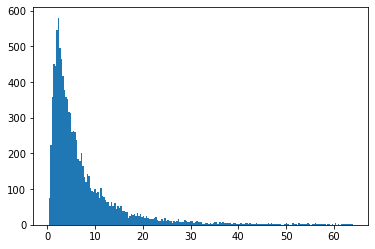

In [96]:
# Price per 1000 calories
df_filter = df.sort_values(by=['price_1000_calories']).iloc[0:round(len(df)*0.95)] # exclude top 5%
hist = plt.hist(df_filter['price_1000_calories'], bins = 200)
# Export data to CSV
df_hist = pd.DataFrame()
df_hist['x_start'] = hist[1][0:len(hist[0])]
df_hist['x_end'] = hist[1][1:(len(hist[0])+1)]
df_hist['y'] = hist[0]
df_hist.to_csv(DIR_DATA_ANIMATIONS+'histogram_calories.csv', index=False)

In [97]:
fig = px.histogram(df_filter, x="price_1000_calories")
fig.show()
fig.update_layout(template='plotly_dark')

import plotly.graph_objects as go
# Update the color of the histogram bars to blue
fig.update_traces(marker_color='blue')

fig.write_html(DIR_DATA_ANIMATIONS + "hist_calories.html")

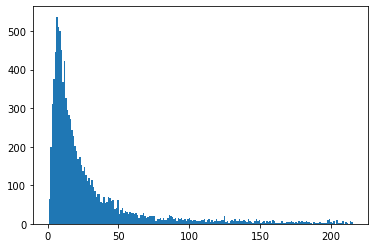

In [103]:
# Price per 100g of protein
df_filter_protein = df[df['price_100g_protein'] != math.inf]
df_filter_protein = df_filter_protein.sort_values(by=['price_100g_protein']).iloc[0:round(len(df)*0.90)] # exclude top 5%
hist = plt.hist(df_filter_protein['price_100g_protein'], bins = 200)
# Export data to CSV
df_hist = pd.DataFrame()
df_hist['x_start'] = hist[1][0:len(hist[0])]
df_hist['x_end'] = hist[1][1:(len(hist[0])+1)]
df_hist['y'] = hist[0]
df_hist.to_csv(DIR_DATA_ANIMATIONS+'histogram_protein.csv', index=False)

#### 2.3.2 Bar Charts with Food Macros

In [99]:
#(!!) Complete for all products
df_chart = df.sort_values(by=['price_1000_calories']).iloc[0:50]
df_chart = df_chart.sort_values(by=['price_1000_calories'], ascending = False)
fig = go.Figure()
fig.add_trace(go.Bar(
    y=df_chart['product_amount'],
    x=df_chart['perc_calories_protein'],
    name='Protein',
#     text=[str(x) for x in round(100*df_chart['perc_calories_protein'],1)],
    marker=dict(
        color='#d83a33'
    ),
    orientation='h',
))
fig.add_trace(go.Bar(
    y=df_chart['product_amount'],
    x=df_chart['perc_calories_fat'],
    name='Fat',
#     text=[str(x) for x in round(100*df_chart['perc_calories_fat'],1)],
    marker=dict(
        color='#2ec2a0'
    ),
    orientation='h',
))
fig.add_trace(go.Bar(
    y=df_chart['product_amount'],
    x=df_chart['perc_calories_carbs'],
#     text=str(round(100)),
#     text=[str(x) for x in round(100*df_chart['perc_calories_carbs'],1)],
    name='Carbs',
    marker=dict(
        color='#f4b430'
    ),
    orientation='h',
))
# fig = px.bar(df_chart, x =["perc_calories_protein","perc_calories_fat"], y="product", orientation='h',
#              hover_data=["product", "perc_calories_protein"],
#              height=1000,
#              title='Macro Bar Chart')
fig.update_layout(barmode='stack', height=1500, template='plotly_dark')
#                   , paper_bgcolor="#000000", font_color="white")
fig.update_xaxes(categoryorder='array', categoryarray= df_chart['product'])
fig.show()
fig.write_html(DIR_DATA_ANIMATIONS + "macros_calories_cheap.html")

#### 2.3.3 Scatter Plots

In [112]:
#2D
fig = px.scatter(df[(df['price_100g_protein']<100)], x='perc_calories_protein', y ='price_100g_protein', hover_data=['product'], size = 'protein')
fig.show()
fig.write_html(DIR_DATA_ANIMATIONS + "scatter_protein.html")

In [101]:
# df_scatter_3d = df[(df['price_100g_protein']<100) & (df['perc_calories_protein']>0.20)]
df_scatter_3d = df[(df['price_100g_protein']<100)]
# df_scatter_3d = df[(df['price_100g_protein']<50)]
fig = px.scatter_3d(df_scatter_3d, x='perc_calories_protein', y ='perc_calories_carbs', z='price_100g_protein', hover_data=['product','url','price'], size = 'protein')
fig.write_html(DIR_DATA_ANIMATIONS + "scatter_protein_3d.html")
fig.show()
df_scatter_3d = df_scatter_3d[['product_amount','perc_calories_protein','perc_calories_carbs','price_100g_protein', 'protein', 'vegan']]
df_scatter_3d.to_csv(DIR_DATA_ANIMATIONS+'df_scatter_plot.csv', index=True)
len(df_scatter_3d)

9554

# 3. Share Data

In [110]:
df_share = df[[
    'product',
    'url',
    'price',
    'amount',
    'unit',
    'nutriscore',
    "carbs_100g",
    "protein_100g",
    "fat_100g",
    "alcohol_100g",
    "calories_100g",
    "calories",
    "protein",
    "carbs",
    "fat",
    "alcohol",
    "perc_calories_protein",
    "perc_calories_carbs",
    "perc_calories_fat",
    "perc_calories_alcohol",
    "price_1000_calories",
    "price_100g_protein",
    "price_100g_carbs",
    "price_100g_fat"
]]
df_share.to_csv('ah_nutrition_data.csv', index = False)

In [108]:
df.iloc[1]

product                                               AH Beschuit volkoren
url                      https://www.ah.nl/producten/product/wi1625/ah-...
category                   ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60
price                                                                 0.49
amount                                                               140.0
content                  Inhoud en gewicht140 GramPortiegrootte: 11 gra...
unit                                                                     g
vegan                                                                False
vegetarian                                                            True
nutriscore                                                               A
carbs_100g                                                            68.0
protein_100g                                                          15.0
fat_100g                                                               5.4
alcohol_100g             